# Popova Model

cf. <a href=https://scholar.google.com/citations?view_op=view_citation&hl=en&user=0BVB3sIAAAAJ&citation_for_view=0BVB3sIAAAAJ:eQOLeE2rZwMC>Popova, Popova, & George, 2008, Bayesian Forecasting of Prepayment Rates for Individual Pools of Mortgages</a>.

Endo is defined as the log of Actual Payment, which is the difference in UPB in a given period. In other words, it includes both prepayment and expected decline in principle.

Betas are:
* incentive: WAC - prevailing mortgage rate, as before
* spline: incentive cubed
* burnout: log ratio of pool_upb to scheduled balance, $B_t$
    * $B_t =  B_0 * \frac{(1 + \tfrac{c}{12})^n - (1+\tfrac{c}{12})^t}{(1+\tfrac{c}{12})^n-1}$, where t=WALA, c=WAC, and n=WARM+WAC (should be 360)
* seasonality: 1 if it's the summer-time, i.e. May-August.
* yield_curve: 10Y rate minus 2Y rate

I'm also using a filtered dataset that only includes GNM II Single Family mortgages. There are about 45,000 pools in this dataset.

They estimate as a mixed effects model. I don't see any provision for the differing loan sizes of these pools. But I'll fit it as it looks in their paper first.

In [1]:
import os
os.chdir("/home/charles/src/LondonMirror/Prepayments/")

import prepayments as pp
import numpy as np
import pandas as pd
import ggplot as gg
import datetime

NEW_DATA = True

ppm = pp.models.PopovaPoolModel()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
if NEW_DATA:
    data = ppm._get_samples_with_old_dates(n=5000)
    data = pd.DataFrame.from_records([x for x in data if x]).dropna()
else:
    data = pd.read_csv("/data/prepayments/samples_ppm.csv")

ERROR:root:Pools table has no records for 36294PV59
ERROR:root:Pools table has no records for 36220MCS6
ERROR:root:Pools table has no records for 36294UH70
ERROR:root:Pools table has no records for 36208L7J0
ERROR:root:One of wac, wala, or warm is missing for 36202CNR0, 2016-06-01.
ERROR:root:One of wac, wala, or warm is missing for 36212LDK4, 2013-12-01.
ERROR:root:Pools table has no records for 36202FBZ8
ERROR:root:Pools table has no records for 36296RN37
ERROR:root:Pools table has no records for 36295KCG6
ERROR:root:One of wac, wala, or warm is missing for 36202DV40, 2016-11-01.
ERROR:root:One of wac, wala, or warm is missing for 36202DXE6, 2014-06-01.
ERROR:root:One of wac, wala, or warm is missing for 36202EP94, 2015-05-01.
ERROR:root:One of wac, wala, or warm is missing for 36230PEN6, 2015-10-01.
ERROR:root:Not enough data to calculate payments for 36295YQW6
ERROR:root:One of wac, wala, or warm is missing for 36202EUW7, 2015-10-01.
ERROR:root:Not enough data to calculate payments

Let's take a look at distributions first.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4963
Data columns (total 16 columns):
burnout              4847 non-null float64
coupon               4847 non-null float64
cusip                4847 non-null object
dt                   4847 non-null datetime64[ns]
endo                 4847 non-null float64
incentive            4847 non-null float64
log_endo             4847 non-null float64
mtg_rate             4847 non-null float64
original_balance     4847 non-null int64
scheduled_payment    4847 non-null float64
seasonality          4847 non-null int64
spline               4847 non-null float64
wac                  4847 non-null float64
wala                 4847 non-null int64
warm                 4847 non-null int64
yc                   4847 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 643.7+ KB


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


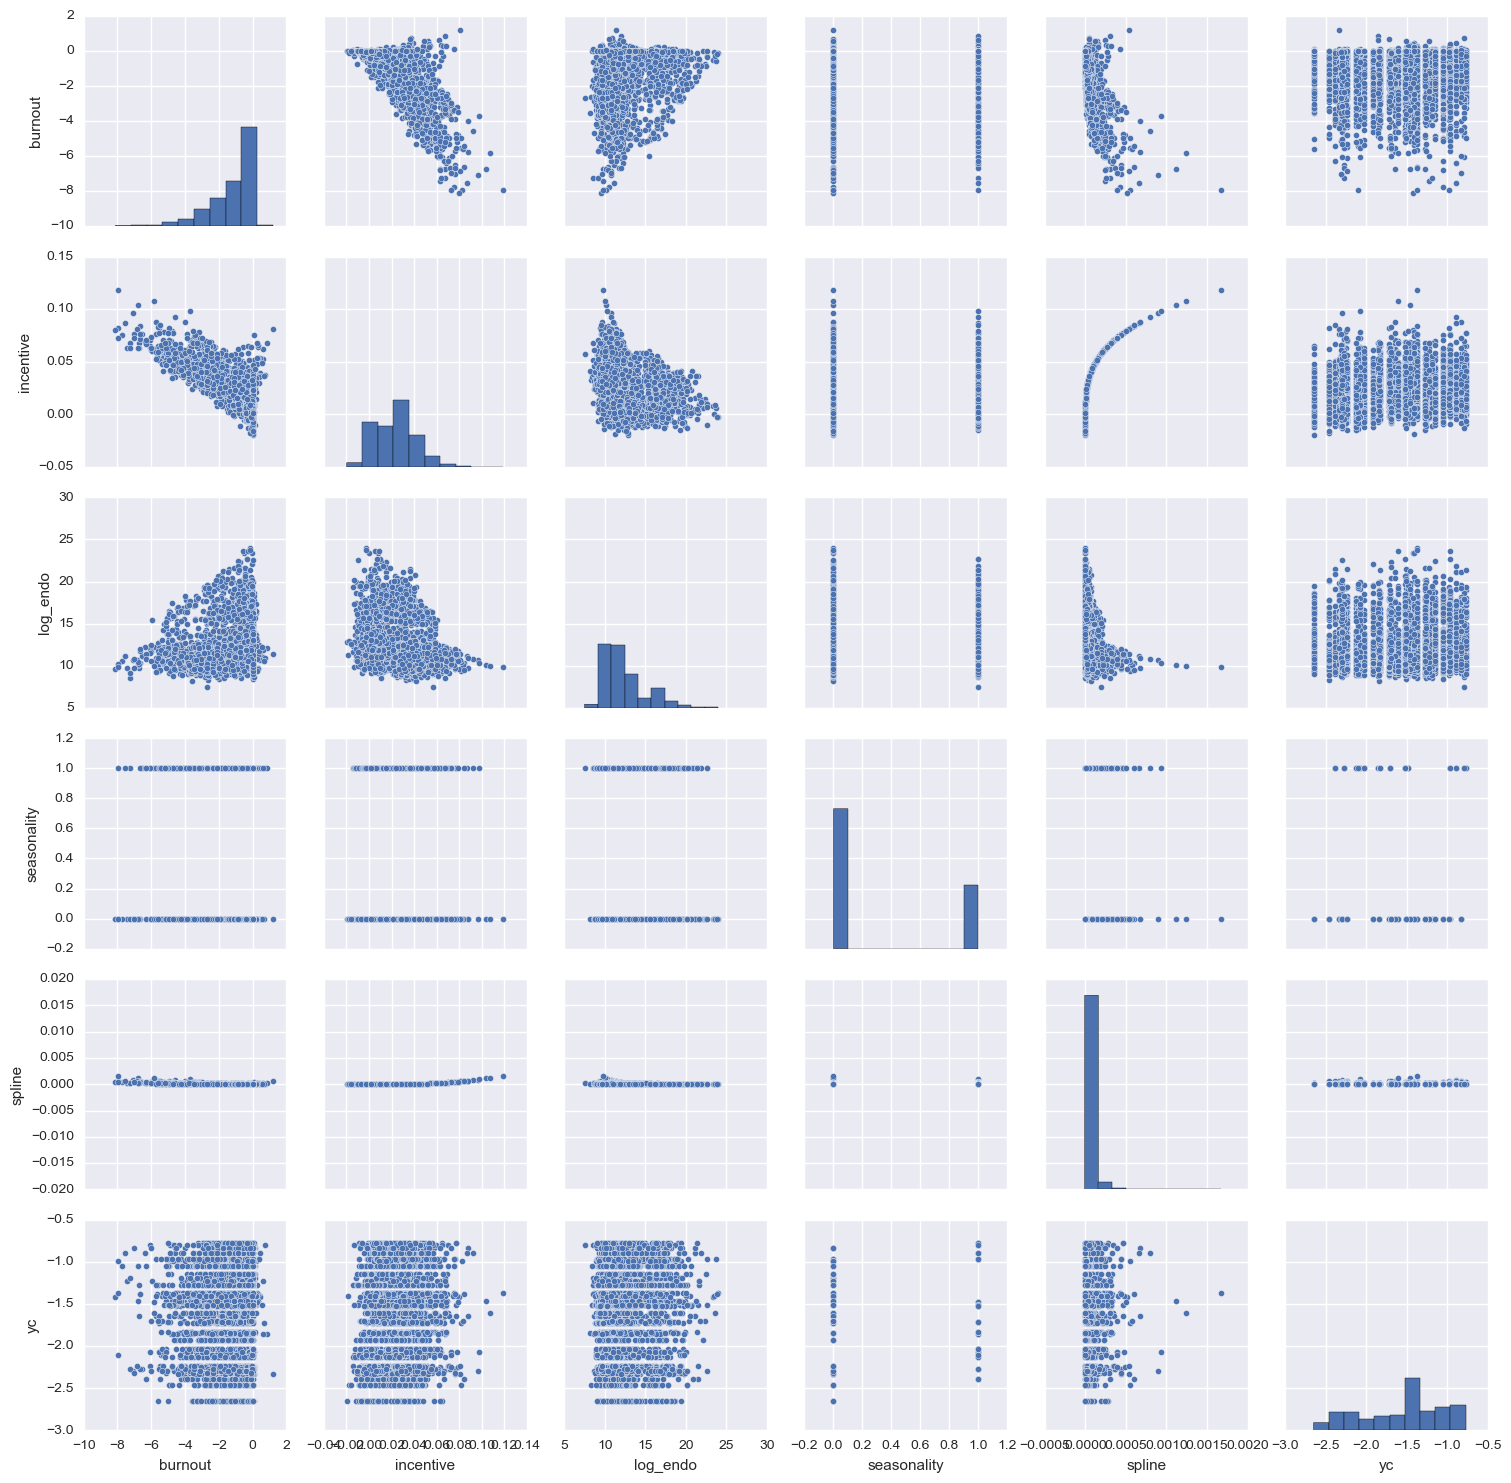

In [8]:
import seaborn as sns
sns.pairplot(data.ix[data.burnout > -np.inf,
                     [x for x in data.columns if x in ['burnout','log_endo','incentive','spline',
                                                      'seasonality','yc']]])

And there, ladies and gentleman, is my f'ing problem. This:

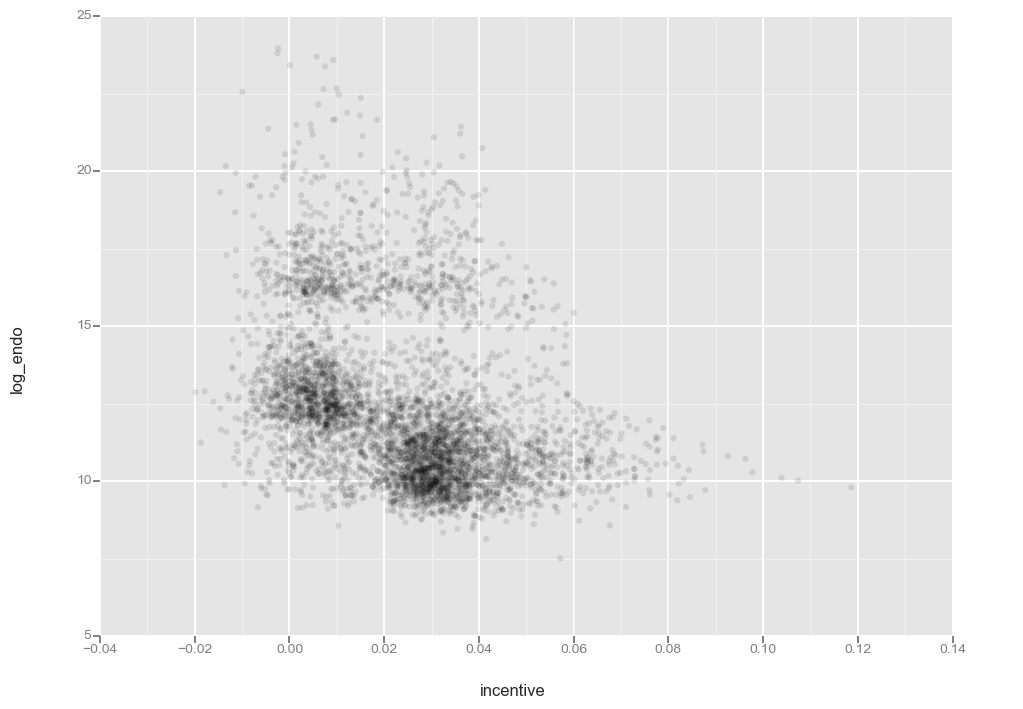

<ggplot: (8757852413093)>

In [9]:
gg.ggplot(data,gg.aes(y='log_endo',x='incentive')) + gg.geom_point(alpha=0.1)

Is never going to have a positive slope. There may be an interesting interaction with the date, though.

In [14]:
data['year'] = [x.year for x in data.dt]
data['month'] = [x.month for x in data.dt]

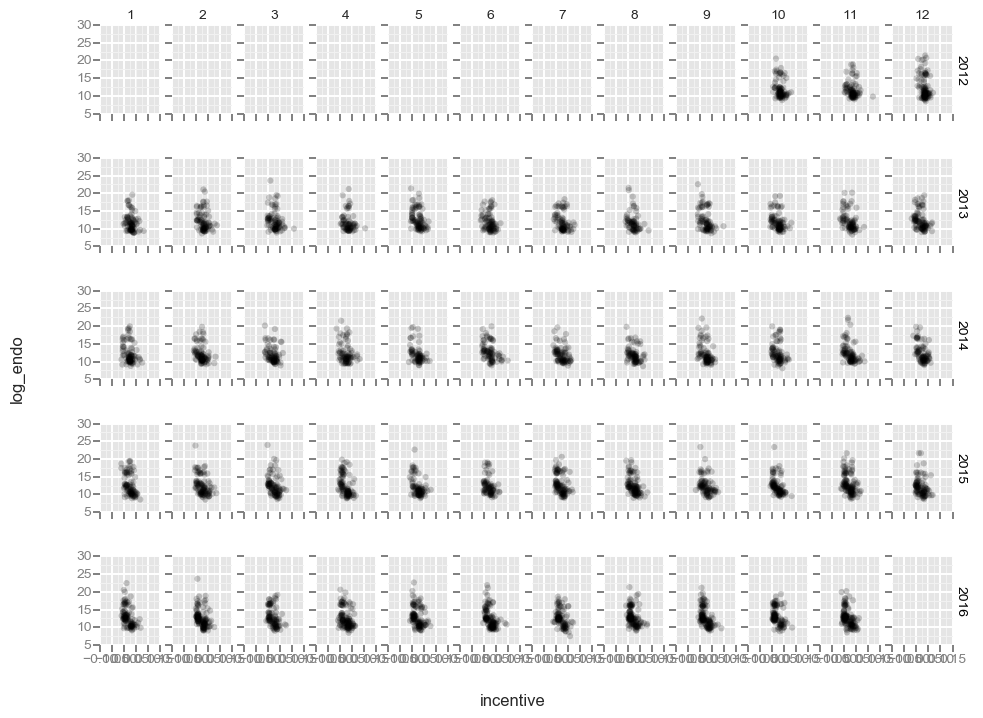

<ggplot: (8757853179945)>

In [15]:
gg.ggplot(data,gg.aes(y='log_endo',x='incentive')) + gg.geom_point(alpha=0.2) + \
    gg.facet_grid('year','month')

Nope.

I think it's time to look at pools over their lifetimes. I'm getting nowhere sampling random months and pools.

Better run this model anyway, though.

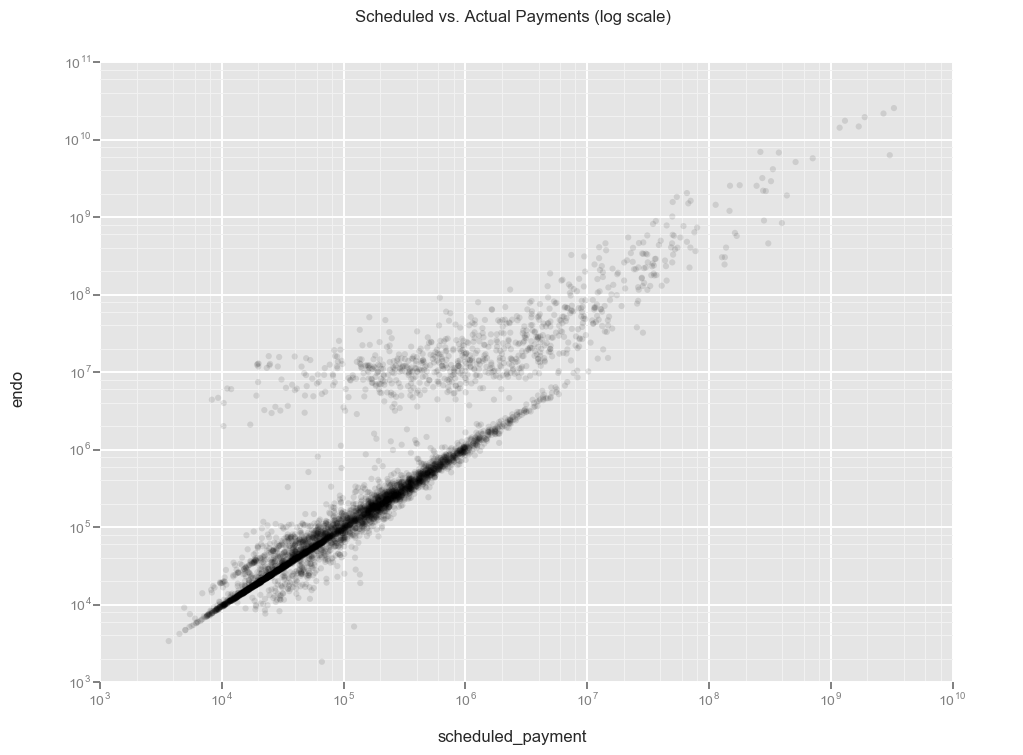

<ggplot: (8757853193013)>

In [16]:
gg.ggplot(data,gg.aes(x='scheduled_payment',y='endo')) + gg.geom_point(alpha=0.1) + \
    gg.scale_x_log() + gg.scale_y_log() + gg.ggtitle("Scheduled vs. Actual Payments (log scale)")

The cluster above the diagonal would be prepayments. It's astonishing that there's such a gap here, though. There really is a totally different cohort here. Supports mixture model.

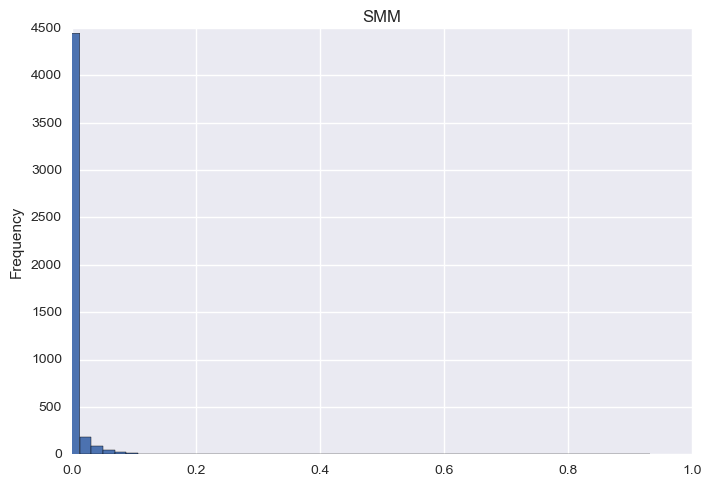

In [17]:
data.endo.sub(data.scheduled_payment).div(data.original_balance).plot.hist(bins=50,xlim=(0,1), title="SMM")

# Scaling
Need to normalize data

In [19]:
pd.DataFrame({'min':data.min(),'med':data.median(),'max':data.max(), 'scalar':1/data.std()})

,max,med,min,scalar
burnout,1.20241,-7.015725e-01,-8.1396,7.575497e-01
coupon,1.01083,1.004375e+00,1.00125,8.208908e+02
cusip,36297JHQ0,NaN,36176A5R6,NaN
dt,2016-11-01 00:00:00,NaN,2012-10-01 00:00:00,NaN
endo,2.54383e+10,1.210240e+05,1825,1.392668e-09
incentive,0.1186,2.500187e-02,-0.0198,5.615337e+01
log_endo,23.9595,1.170374e+01,7.50934,3.893203e-01
month,12,7.000000e+00,1,2.863076e-01
mtg_rate,0.0451,3.300533e-02,0.0261,2.489949e+02
original_balance,2018609583700,1.574468e+08,2525000,1.527622e-11


In [20]:
scaled_data = pd.DataFrame(dict(incentive=data.incentive.mul(50),
                                spline=data.spline.mul(1.3e+04),
                                burnout=data.burnout, 
                                seasonality=data.seasonality,
                                yc=data.yc * 2.
                               ))

In [21]:
import pystan

Here's one with the regression as a multiplier against the scheduled payment.

In [24]:
stan_code = """data {
    int N; #Number of records
    int K; #number of distributions in the mixture
    int B; #number of betas
    vector[N] y; #log(actual_payments)
    row_vector[N] sp; #log(scheduled_payments)
    matrix[N,B] x; #factors: incentive, spline, burnout, season, yc
}
parameters {
    row_vector[B] beta[K]; #betas for each mixture
    real<lower=0> sigma[K]; #scale for y
    simplex[K] p; #mixture proportions
}
transformed parameters {
    row_vector[N] mu[K]; 
    for(k in 1:K) {
        mu[k] = sp .* (beta[k] * x');
    }
}
model {
    real ps[K]; #Temp for log component densities
    for(k in 1:K) {
        beta[k] ~ normal(0,10);
    }
    p ~ dirichlet(rep_vector(0.5,K));
    for(n in 1:N) {
        for(k in 1:K) {
            ps[k] = log(p[k]) + normal_lpdf(y[n] | mu[k,n], sigma[k]);    
        }
        target += log_sum_exp(ps);
    }
}
"""

In [25]:
sm = pystan.StanModel(model_code=stan_code, model_name='mixed_nointercept')

In [46]:
data.shape

(4852, 13)

In [26]:
data['log_sp'] = [np.log(x) for x in data.scheduled_payment]

In [27]:
fit = sm.sampling(data=dict(N=data.shape[0], K=2, B=5, y=data.log_endo, sp=data.log_sp,
                           x=scaled_data.ix[:,['incentive','spline','burnout','seasonality','yc']]),
                 iter=2000, chains=4)

In [32]:
params = fit.extract(permuted=True)

In [35]:
params.keys()

[u'beta', u'sigma', u'p', u'mu', u'lp__']

bleh. need to do this in R.

In [40]:
data.to_csv("popova_data.csv")